In [1]:
import sys
sys.path.append('../')
import pandas
import matplotlib.pyplot as plt
import seaborn
import qgrid

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu


from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [2]:
base_reward = rewards.RewardV1
class new_reward(base_reward):
    max_speed    = 1.0

In [3]:
factory = RewardFactory(base_reward)

In [10]:
import os
import pathlib
base_folder = '../logs'
df_list = list()
big_training_panda = None

base_path = pathlib.Path(base_folder)
stream_names = [path.name for path in base_path.glob('training*')]

for stream in stream_names:
    print(f'Loading:{stream}')
    df = load_logs('%s/%s' % (base_folder, stream))
    df['stream'] = stream
    if big_training_panda is not None:
        big_training_panda = big_training_panda.append(df)
    else:
        big_training_panda = df

Loading:training-simulation-logs-z7.log
Loading:training-simulation-logs-w5.log
Loading:training-simulation-logs-z5.log
Loading:training-simulation-logs-z4-2.log
Loading:training-simulation-logs-z2.log
Loading:training-simulation-logs-w4.log
Loading:training-simulation-logs-w7.log
Loading:training-simulation-logs-y1.log
Loading:training-simulation-logs-w2.log
Loading:training-simulation-logs-y2.log
Loading:training-simulation-logs-z6.log
Loading:training-simulation-logs-z4.log
Loading:training-simulation-logs-w6.log
Loading:training-simulation-logs-z3.log
Loading:training-simulation-logs-w3.log
Loading:training-simulation-logs-z1.log
Loading:training-simulation-logs-x1.log


In [11]:
factory.calculate_new_reward(big_training_panda, track.center_line,df_to_params,'new_reward',missing_params=None)

In [12]:
big_training_panda = new_names_df(big_training_panda)
# big_training_panda
# big_training_panda.columns = ['episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle',
#        'action_taken', 'reward', 'done', 'on_track', 'progress',
#        'closest_waypoint', 'track_len', 'tts', 'status', 'timestamp',
#        'stream', 'new_reward']
# big_training_panda.dtypes

In [13]:
# Below code is using stream name as part of grouping since otherwise there would be episode number collisions
big_simulation_agg = au.simulation_agg(big_training_panda, 'stream')

big_complete_ones = big_simulation_agg[big_simulation_agg['progress']==100]

In [14]:
qgrid.show_grid(big_complete_ones)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

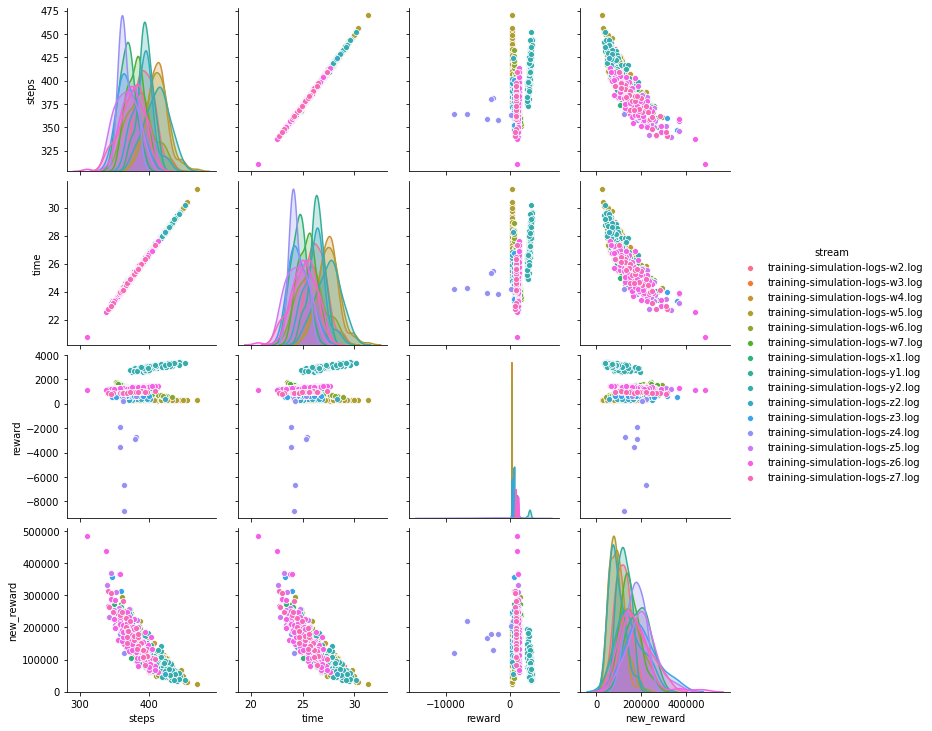

In [15]:
seaborn.pairplot(big_complete_ones[['steps','time','reward','new_reward','stream']],hue='stream',palette="husl")

In [16]:
sample_complete_laps = ( big_complete_ones.nlargest(10,['time']).copy(deep=True)
        .append([ big_complete_ones.nsmallest(10,['time']), big_complete_ones.sample(20)] )
        .drop_duplicates().sort_values(by='time').reset_index() )
# sample_complete_laps[['stream','episode','time']].to_csv('../logs/sample_complete_laps.csv')

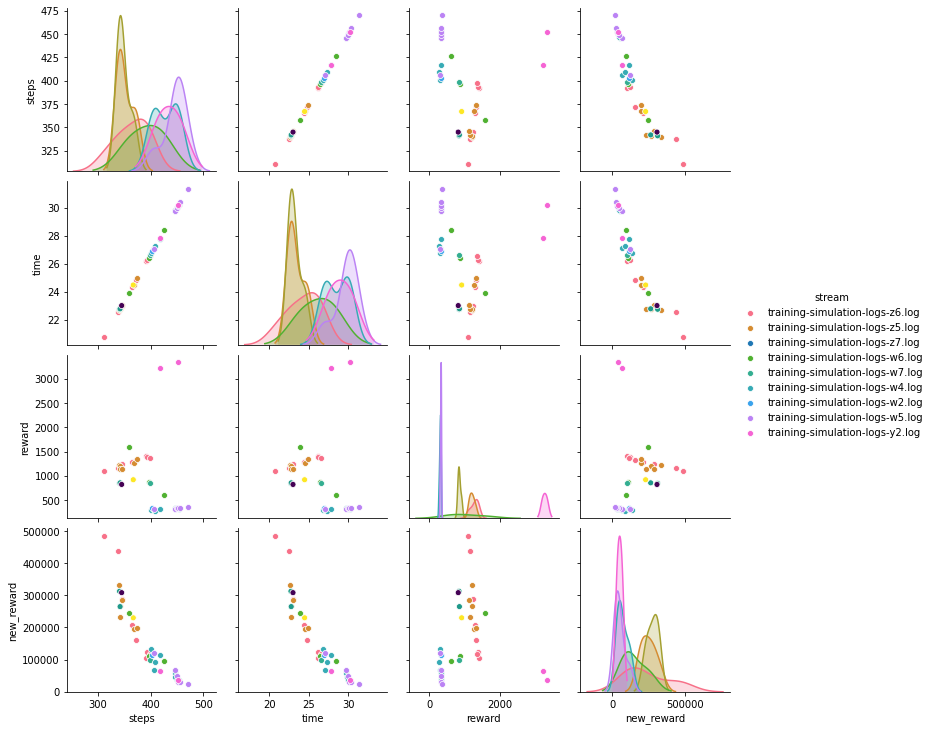

In [17]:
seaborn.pairplot(sample_complete_laps[['steps','time','reward','new_reward','stream']],hue='stream',palette="husl")